# Rewriting/Reorganizing the codebase for EnKF

## Farsite

### Config File

In [1]:
import datetime
import os
import pathlib
import uuid

from shapely import Polygon, make_valid, GeometryCollection, MultiPolygon

from dsfunctions import get_observation
from pyproj import Transformer

import pandas as pd
import geopandas as gpd

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

class Config_File:
    def __init__(self, 
                 FARSITE_START_TIME: datetime.datetime, 
                 FARSITE_END_TIME: datetime.datetime, 
                 windspeed: int, winddirection: int):
        self.__set_default()
        
        # Set the parameters
        self.FARSITE_TIMESTEP = int((FARSITE_END_TIME - FARSITE_START_TIME).total_seconds()/60)
        self.FARSITE_START_TIME = datetime.datetime(2019, 9, 9, 19, 0)
        self.FARSITE_END_TIME = self.FARSITE_START_TIME + (FARSITE_END_TIME - FARSITE_START_TIME)
        self.windspeed = windspeed
        self.winddirection = winddirection

    def __set_default(self):
        self.version = 1.0
        self.FARSITE_DISTANCE_RES = 30
        self.FARSITE_PERIMETER_RES = 60
        self.FARSITE_MIN_IGNITION_VERTEX_DISTANCE = 15.0
        self.FARSITE_SPOT_GRID_RESOLUTION = 60.0
        self.FARSITE_SPOT_PROBABILITY = 0  # 0.9
        self.FARSITE_SPOT_IGNITION_DELAY = 0
        self.FARSITE_MINIMUM_SPOT_DISTANCE = 60
        self.FARSITE_ACCELERATION_ON = 1
        self.FARSITE_FILL_BARRIERS = 1
        self.SPOTTING_SEED = 253114
        
        self.FUEL_MOISTURES_DATA = [[0, 3, 4, 6, 30, 60]]
        
        self.RAWS_ELEVATION = 2501
        self.RAWS_UNITS = 'English'
        # Add self.raws from the init
              
        self.FOLIAR_MOISTURE_CONTENT = 100
        self.CROWN_FIRE_METHOD = 'ScottReinhardt'
        
        self.WRITE_OUTPUTS_EACH_TIMESTEP = 0
        
        self.temperature = 66
        self.humidity = 8
        self.precipitation = 0
        self.cloudcover = 0
        
    def tostring(self):
        config_text = 'FARSITE INPUTS FILE VERSION {}\n'.format(self.version)
        
        str_start = '{month} {day} {time}'.format(
                            month = self.FARSITE_START_TIME.month,
                            day = self.FARSITE_START_TIME.day,
                            time = '{}{:02d}'.format(
                                    self.FARSITE_START_TIME.hour,
                                    self.FARSITE_START_TIME.minute))
        config_text += 'FARSITE_START_TIME: {}\n'.format(str_start)

        str_end = '{month} {day} {time}'.format(
                            month = self.FARSITE_END_TIME.month,
                            day = self.FARSITE_END_TIME.day,
                            time = '{}{:02d}'.format(
                                    self.FARSITE_END_TIME.hour,
                                    self.FARSITE_END_TIME.minute))
        config_text += 'FARSITE_END_TIME: {}\n'.format(str_end)
        
        config_text += 'FARSITE_TIMESTEP: {}\n'.format(self.FARSITE_TIMESTEP)
        config_text += 'FARSITE_DISTANCE_RES: {}\n'.format(self.FARSITE_DISTANCE_RES)
        config_text += 'FARSITE_PERIMETER_RES: {}\n'.format(self.FARSITE_PERIMETER_RES)
        config_text += 'FARSITE_MIN_IGNITION_VERTEX_DISTANCE: {}\n'.format(self.FARSITE_MIN_IGNITION_VERTEX_DISTANCE)
        config_text += 'FARSITE_SPOT_GRID_RESOLUTION: {}\n'.format(self.FARSITE_SPOT_GRID_RESOLUTION)
        config_text += 'FARSITE_SPOT_PROBABILITY: {}\n'.format(self.FARSITE_SPOT_PROBABILITY)
        config_text += 'FARSITE_SPOT_IGNITION_DELAY: {}\n'.format(self.FARSITE_SPOT_IGNITION_DELAY)
        config_text += 'FARSITE_MINIMUM_SPOT_DISTANCE: {}\n'.format(self.FARSITE_MINIMUM_SPOT_DISTANCE)
        config_text += 'FARSITE_ACCELERATION_ON: {}\n'.format(self.FARSITE_ACCELERATION_ON)
        config_text += 'FARSITE_FILL_BARRIERS: {}\n'.format(self.FARSITE_FILL_BARRIERS)
        config_text += 'SPOTTING_SEED: {}\n'.format(self.SPOTTING_SEED)
        
        # Fuel moistures
        config_text += 'FUEL_MOISTURES_DATA: {}\n'.format(len(self.FUEL_MOISTURES_DATA))
        for data in self.FUEL_MOISTURES_DATA:
            config_text += '{} {} {} {} {} {}\n'.format(data[0], data[1], data[2],
                                                      data[3], data[4], data[5])
            
        config_text += 'RAWS_ELEVATION: {}\n'.format(self.RAWS_ELEVATION)
        config_text += 'RAWS_UNITS: {}\n'.format(self.RAWS_UNITS)
        
        # Weather data (currently only a single weather data)
        config_text += 'RAWS: 1\n'
        config_text += '{year} {month} {day} {time} {temperature} {humidity} {precipitation} {windspeed} {winddirection} {cloudcover}\n'.format(
                                year = self.FARSITE_START_TIME.year,
                                month = self.FARSITE_START_TIME.month,
                                day = self.FARSITE_START_TIME.day,
                                time = '{}{:02d}'.format(
                                    self.FARSITE_START_TIME.hour, 
                                    self.FARSITE_START_TIME.minute),
                                temperature = self.temperature,
                                humidity = self.humidity,
                                precipitation = self.precipitation,
                                windspeed = self.windspeed,
                                winddirection = self.winddirection,
                                cloudcover = self.cloudcover
                            )
        config_text += 'FOLIAR_MOISTURE_CONTENT: {}\n'.format(self.FOLIAR_MOISTURE_CONTENT)
        config_text += 'CROWN_FIRE_METHOD: {}\n'.format(self.CROWN_FIRE_METHOD)
        config_text += 'WRITE_OUTPUTS_EACH_TIMESTEP: {}'.format(self.WRITE_OUTPUTS_EACH_TIMESTEP)
        
        return config_text
    
    def to_file(self, filepath: str):
        with open(filepath, mode='w') as file:
            file.write(self.tostring())


class Run_File:
    def __init__(self, lcppath: str, cfgpath: str, ignitepath: str, barrierpath: str, outpath: str):
        self.lcppath = lcppath
        self.cfgpath = cfgpath
        self.ignitepath = ignitepath
        self.barrierpath = barrierpath
        self.outpath = outpath

    def tostring(self):
        return '{lcpath} {cfgpath} {ignitepath} {barrierpath} {outpath} -1'.format(
                                lcpath =  self.lcppath, 
                                cfgpath = self.cfgpath, 
                                ignitepath = self.ignitepath, 
                                barrierpath = self.barrierpath, 
                                outpath = self.outpath)
    def to_file(self, filepath: str):
        with open(filepath, mode='w') as file:
            file.write(self.tostring())

def generate_landscape(geom_5070: Polygon, description='test'):
    bounds = geom_5070.bounds

    ulx = bounds[0]-10000
    uly = bounds[3]+10000
    lrx = bounds[2]+10000
    lry=  bounds[1]-10000

    fname_lst = {'density': 'US_140CBD_12052016/Grid/us_140cbd', 
                 'base': 'US_140CBH_12052016/Grid/us_140cbh', 
                 'cover': 'US_140CC_12052016/Grid/us_140cc', 
                 'height': 'US_140CH_12052016/Grid/us_140ch', 
                 'fuel': 'US_140FBFM40_20180618/Grid/us_140fbfm40', 
                 'aspect': 'Aspect/Grid/us_asp', 
                 'elevation': 'DEM_Elevation/Grid/us_dem', 
                 'slope': 'Slope/Grid/us_slp'}
    type_lst = {'density': 'cbd',
                'base': 'cbh',
                'cover': 'cc',
                'height': 'ch',
                'fuel': 'fuel',   # fbfm40
                'aspect': 'aspect',
                'elevation': 'elevation', #dem
                'slope': 'slope'}

    from_folder = os.path.join('/data', 'firemap', 'landfire', 'mosaic')
    to_folder = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'inputs', 'landscapes')

    # Create the asc files
    ascpath_lst = {}
    for (key, fname) in fname_lst.items():
        ascpath_lst[key] = f'{os.path.join(to_folder, description)}-{key}.asc'
        
        run_script = f'gdal_translate -of AAIGrid -a_nodata -32768 -projwin {ulx} {uly} {lrx} {lry} {os.path.join(from_folder, fname)} {ascpath_lst[key]}'
        os.system(run_script)
        
    lcppath = os.path.join(to_folder, description)
    lcpmakepath = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'src', 'lcpmake')

    x,y = geom_5070.centroid.xy
    
    transformer = Transformer.from_crs(5070, 4326, always_xy=True)
    lat = transformer.transform(x[0], y[0])[1]
    
    base_command = f'{lcpmakepath} -latitude {lat} -landscape {lcppath}'
    run_command = base_command
    for (key, ascpath) in ascpath_lst.items():
        run_command += f' -{key} {ascpath}'

    os.system(run_command)
    
    # Remove unused files
    os.system(f"rm {os.path.join(to_folder, f'{description}*asc')} {os.path.join(to_folder, f'{description}*xml')} {os.path.join(to_folder, f'{description}*prj')}")
    
    
    # Copy 5070 projection to use it in farsite
    os.system(f"cp {os.path.join(to_folder, '5070.prj')} {os.path.join(to_folder, f'{description}.prj')}")
    return lcppath



class Farsite:
    def __init__(self, initial: Polygon, params: dict, description: str, 
                 lcppath: str = None, barrierpath: str = None):
        
        self.farsitepath = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'TestFARSITE')        
        self.id = uuid.uuid4().hex

        self.tmpfolder = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'data', 'tmp',
                                      datetime.datetime.today().strftime('%Y%m%d'))
        pathlib.Path(self.tmpfolder).mkdir(parents=True, exist_ok=True) 
        

        # Setup files
        self.lcppath = lcppath + '.lcp'
        
        if lcppath == None:
            raise ValueErorr(f'The filepath {lcppath} cannot be used for lcppath')
            

        start_dt = datetime.datetime(year=2019, month=1, day=1, hour=10, minute=0)
        end_dt = start_dt + params['dt']
        windspeed = params['windspeed']
        winddirection = params['winddirection']
        
        self.config = Config_File(start_dt, end_dt, windspeed, winddirection)
        self.configpath = os.path.join(self.tmpfolder, f'{description}_config_{self.id}.cfg')
        self.config.to_file(self.configpath)
        
        
                
        #### RUN FILE PREPARATION ####
        # Barrier file
        self.barrierpath = barrierpath
        if self.barrierpath == None: # Use No Barrier
            self.barrierpath = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'inputs', 'barriers', 'NoBarrier', 'NoBarrier.shp')
            
        
        # Ignite path
        self.ignitepath = os.path.join(self.tmpfolder, f'{description}_ignite_{self.id}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': [initial]}).to_file(self.ignitepath)
        
        
        # Output path
        self.outpath = os.path.join(self.tmpfolder, f'{description}_out_{self.id}')
                                    
        
        # Generate RunFile
        self.runfile = Run_File(self.lcppath, self.configpath, self.ignitepath, self.barrierpath, self.outpath)
        self.runpath = os.path.join(self.tmpfolder, f'{description}_run_{self.id}')
        self.runfile.to_file(self.runpath)

    def run(self, timeout=5, ncores=4):
        self.command = f'timeout {timeout}m {self.farsitepath} {self.runpath} {ncores} > output.out 2> output.err'  # donot run 
        os.system(self.command)
        
    def output_geom(self):
        geom = gpd.read_file(self.outpath + '_Perimeters.shp')['geometry'][0]
        return Polygon(geom.coords)
        
    def __del__(self):
        os.system(f'rm {os.path.join(self.tmpfolder, f"{description}_*_{self.id}*")}')
#         print(f'del is called for {self.id}')
        # Run farsite
        # Returns final polygon
        
def forward_pass_farsite(poly, params, lcppath, description):
    farsite = Farsite(poly, params, lcppath=lcppath, description=description)
    
#     print('Running Farsite')
    farsite.run()
    
    return farsite.output_geom()




###### MISC ###########
def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly






########## ENKF functions #########

def state_to_geom(state):
    return validate_geom(Polygon(zip(state[::2], state[1::2])))

def geom_to_state(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(2*len(geom.exterior.coords[:-1]), 1)

################# ALIGN GEOMS ####################
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    # if len(vertices) == dnumber:
    #     return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices


def interpolate_geom(geom, vertex_count):
    interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords), vertex_count))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count-1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords), vertex_count+1))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count+1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords), vertex_count-1))

    return interpolated_geom

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms

def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

#############################    
    
    
    
    
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x,y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def adjusted_state_EnKF_farsite(initial_state, observation_state, 
                        X, n_states, n_samples, rng, 
                        sampled_wslst, sampled_wdlst, dt,
                        vsize, wsize, description):

    xkhat_ensemble = np.zeros((n_states, n_samples))
    
    zkphat_ensemble = np.zeros((n_states, n_samples))
    xkphat_ensemble = np.zeros((n_states, n_samples))
    ykhat_ensemble = np.zeros((n_output, n_samples))
    
    Xs = np.linalg.cholesky(X)
    # For each sample
    zero_samples = []
    
    # Generate lcp for initial_state
    
    initial_geom = state_to_geom(initial_state)
    lcppath = generate_landscape(initial_geom, description=description)
    
    for s in tqdm(range(n_samples)):
    
        xkhat_ensemble[:,s:(s+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
        ws = sampled_wslst[s]
        wd = sampled_wdlst[s]

        # Calculate the ensemble for the observations
        # ykhat_ensemble[:,s:(s+1)] = xy_to_state(*sample_xy(observation_state[::2], observation_state[1::2], rng, scale=vsize))
        ykhat_ensemble[:,s:(s+1)] = xkhat_ensemble[:,s:(s+1)] + rng.normal(0, scale=vsize, size=(n_output,1))
########################################
        forward_geom = forward_pass_farsite(state_to_geom(xkhat_ensemble[:,s:(s+1)]),
                                            params={'windspeed': int(ws),
                                                    'winddirection': int(wd),
                                                    'dt': dt},
                                            lcppath=lcppath, 
                                            description=description)
        if forward_geom is None:
            zero_samples.append(s)
            continue
            
        forward_state = geom_to_state(forward_geom)
        aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)

        # Randomness is not given here. It's given later. This is only for calculating the ensembles
#         zkphat_ensemble[:,s:(s+1)] = xy_to_state(aligned_states[1][::2], aligned_states[1][1::2])
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
        
########################################
        

    # Calculate the mean of the non-zero ensembles
    zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(n_samples - len(zero_samples))
    
    # Fill in the zero samples with the mean
    for s in zero_samples:
        zkphat_ensemble[:,s:(s+1)] = zkphat_mean
    
    filled_counts = len(zero_samples)
    
    # zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)
    
    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
    for n in range(n_states):
        ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n] + rng.normal(0, scale=wsize)  # + omega_k^j
    
    eykhat_ensemble = np.zeros_like(ykhat_ensemble)
    for n in range(n_output):
        eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]
    
    Pzy = 1/n_samples*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)
    
    Py = 1/n_samples*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)

    inv_product = np.matmul(Py, Pyinv)
    if not np.allclose(inv_product, np.eye(n_output)):
        print('Inverse calculation is incorrect')
        display(inv_product)
        
    # warnings.warn('Not checking the inverse calculation')
    
    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)
    
    # compute mean valued state adjustment using measurement y(k)
    # yk = geom_to_state(observation['geometry'], n_states, nvertex)
    yk = observation_state
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)
    
    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(n_samples):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])
    
    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    exkphat_ensemble = np.zeros_like(xkphat_ensemble)
    for n in range(n_states):
        exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/n_samples*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)
    
    return adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble



###################
# SAMPLING ########
###################
def sample_geometry(geom, rng, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = rng.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = rng.normal(mu, sigma)
        randy = rng.normal(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def sample_windspeed(loc, sigma, rng):
    ws = rng.normal(loc, sigma)
    if ws < 0:
        ws = 0
    return ws
def sample_winddirection(loc, sigma, rng):
    return np.fmod(rng.normal(loc, sigma)+360, 360)


##### PLOTTING
###############
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    if show_stdev:
        for vix in range(vcounts):
            print(f'Calculating {vix}/{vcounts}..    ', end='\r', flush=True)
            x,y = X[2*vix,:], X[2*vix+1,:]
            radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
            radstd[vix] = np.std(radius)
        print()
        for vix in range(vcounts):
            print(f'Drawing {vix}/{vcounts}..    ', end='\r', flush=True)
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')


### Testing EnKF

In [2]:
description = 'Bridge2021'

for tix in range(10):
    try:
        obs, ts = get_observation(description, tix)
    except Exception as e:
        print(e)
        print(f'No observation found for tix={tix}')
        break

tfin = tix

'/home/tcaglar/farsite-devAPI/inputs/landscapes/Bridge2021.lcp' not recognized as a supported file format.
No observation found for tix=6


In [3]:
if description == 'Maria2019':
    # MAria Fire wind values
    # Windspeed and Wind direction that were used live
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]
    print('Chose Maria fire')
elif description == 'Bridge2021':
    # Bridge fire wind values
    wslst = [15]*(tfin)
    wdlst = [0]*(tfin)
    print('Chose Bridge fire')

# River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

n_vertex = 20
n_samples = 250
wssigma = 5
wdsigma = 90
vsize=100  # Observation uncertainty
wsize=100   # Model uncertainty
rng = np.random.Generator(np.random.PCG64(1234))

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in range(tfin):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)
    sampled_wslst.append([])
    sampled_wdlst.append([])
    for s in range(n_samples):
        sampled_wslst[-1].append(sample_windspeed(wslst[tix],wssigma,rng))
        sampled_wdlst[-1].append(sample_winddirection(wdlst[tix], wdsigma, rng))

Chose Bridge fire


2021-09-05 14:04:52
0 days 00:00:00
0 days 00:29:37
0 days 00:57:24
0 days 01:20:28
0 days 01:53:35
0 days 02:18:39


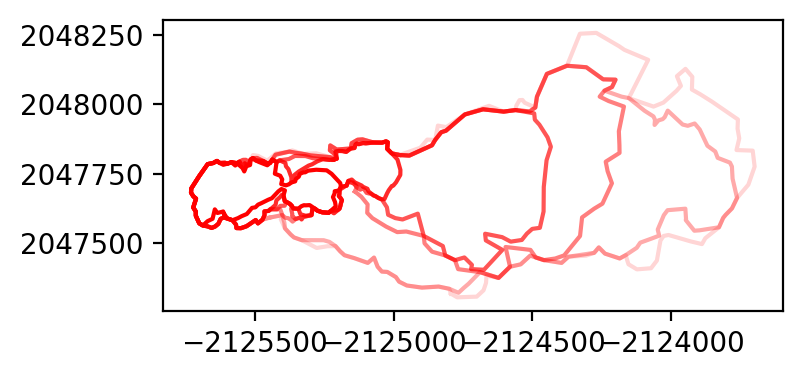

In [4]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

print(timestamps[0])
for i, (geom, dt) in enumerate(zip(observations, timestamps)):
    plot_geometry(validate_geom(geom), ax=ax, color='red', alpha=1-i/len(observations))
    print(dt - timestamps[0])

    
lcppath = generate_landscape(observations[0], description=description)    
# Maria boundaries
# ax.set_xlim(-2.091e6, -2.081e6)
# ax.set_ylim(1.498e6, 1.508e6)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)


# ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

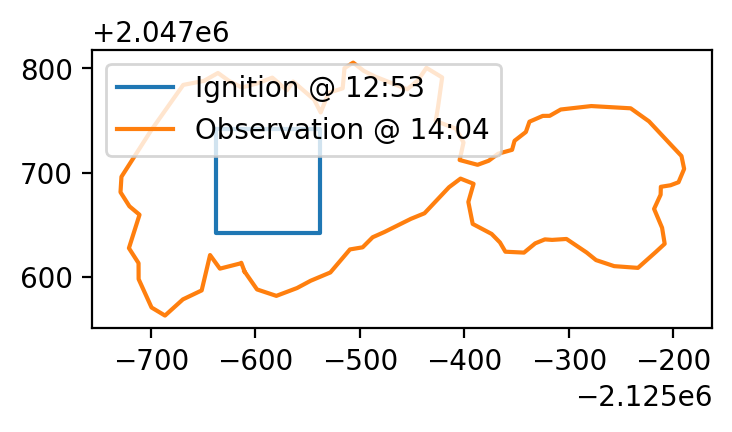

In [5]:
if description == 'Maria2019':
    # Maria ignition
    ignition_timepoint = timestamps[0].replace(hour=18, minute=13)
    x,y = (-2084217.1484733422, 1503560.461310427)
    width = 200
    xshift = 2000
    yshift = 1500
elif description == 'Bridge2021':
    # Bridge2021 ignition
    ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
    x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
    width = 100
    xshift = -50
    yshift = 50



# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax, label=f'Ignition @ {ignition_timepoint.strftime("%H:%M")}')
plot_geometry(observations[0], ax=ax, label=f'Observation @ {timestamps[0].strftime("%H:%M")}')
ax.legend(loc='upper left')

model_output_lst = []
adjusted_geom_lst = []
X_lst = []
xkhat_ensemble_lst = []
xkphat_ensemble_lst = []
ykhat_ensemble_lst = []
zkphat_ensemble_lst = []

In [6]:
# Run farsite from ignition to the first observation
dt = timestamps[0] - ignition_timepoint
wd = wdlst[0]
ws = wslst[0]

model_output = forward_pass_farsite(ignition, params={'windspeed': ws,
                                                 'winddirection': wd,
                                                 'dt': dt},
                                   lcppath=lcppath, description=description)
model_output_lst.append(model_output)

###########################################
#### CALCULATE ADJUSTED MODEL OUTPUT ######
###########################################
# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
tix = 0
initial_state = geom_to_state(ignition)
observation_state = geom_to_state(validate_geom(observations[tix]))

X = 1e3*np.eye(n_states)  # Initial covariance matrix
initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
    initial_state, observation_state, X, n_states, n_samples, 
    rng, sampled_wslst[tix], sampled_wdlst[tix], dt, vsize, wsize, 
    description)

adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
adjusted_geom_lst.append(adjusted_geom)
X_lst.append(X)
xkhat_ensemble_lst.append(xkhat_ensemble)
xkphat_ensemble_lst.append(xkphat_ensemble)
ykhat_ensemble_lst.append(ykhat_ensemble)
zkphat_ensemble_lst.append(zkphat_ensemble)

100%|██████████| 250/250 [00:41<00:00,  6.06it/s]


Calculating 19/20..    


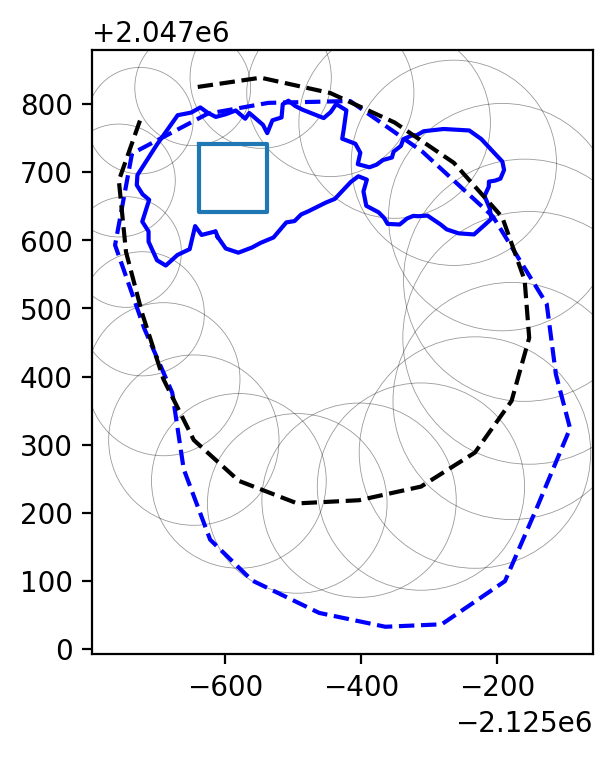

In [7]:
# X=1e1
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(zkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)

In [10]:
%%time

# Run farsite for the rest of the time

for tix in range(1,tfin):
    print(f'\nCalculating {tix}/{tfin}...')
    dt = timestamps[tix] - timestamps[tix-1]
    wd = wdlst[tix]
    ws = wslst[tix]
    
    model_output = forward_pass_farsite(observations[tix-1], {'windspeed': ws,
                                                         'winddirection': wd,
                                                         'dt': dt},
                                        lcppath=lcppath, description=description)
    model_output_lst.append(model_output)
    
    
    ###########################################
    #### CALCULATE ADJUSTED MODEL OUTPUT ######
    ###########################################
    initial_state = geom_to_state(adjusted_geom_lst[tix-1])
    observation_state = geom_to_state(validate_geom(observations[tix]))
    
    initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, X, 
        n_states, n_samples, rng, 
        sampled_wslst[tix], sampled_wdlst[tix], dt,
        vsize, wsize, description)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    adjusted_geom_lst.append(adjusted_geom)
    X_lst.append(X)
    xkhat_ensemble_lst.append(xkhat_ensemble)
    xkphat_ensemble_lst.append(xkphat_ensemble)
    ykhat_ensemble_lst.append(ykhat_ensemble)
    zkphat_ensemble_lst.append(zkphat_ensemble)


Calculating 1/6...


100%|██████████| 250/250 [00:34<00:00,  7.21it/s]



Calculating 2/6...


100%|██████████| 250/250 [00:35<00:00,  7.10it/s]



Calculating 3/6...


100%|██████████| 250/250 [00:43<00:00,  5.76it/s]



Calculating 4/6...


100%|██████████| 250/250 [01:08<00:00,  3.65it/s]



Calculating 5/6...


100%|██████████| 250/250 [01:04<00:00,  3.88it/s]

CPU times: user 46.1 s, sys: 9.87 s, total: 56 s
Wall time: 4min 25s
